In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download(
    "alessandrasala79/ai-vs-human-generated-dataset"
)

print("Path to dataset files:", path)


100%|██████████| 9.76G/9.76G [08:10<00:00, 21.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import collections
import cv2


In [4]:
train_data_dir = path

In [5]:
train_df = pd.read_csv(
    os.path.join(train_data_dir, "train.csv"),
    index_col=0
)

test_df = pd.read_csv(
    os.path.join(train_data_dir, "test.csv")
)

train_df.head()


,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [6]:
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(train_data_dir, x))
train_df['label'] = train_df['label'].astype(str)

In [7]:
print(train_df['label'].value_counts())

label
1    39975
0    39975
Name: count, dtype: int64


In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],
    validation_split=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1
)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_name',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 71955 validated image filenames belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_name',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    shuffle=False
)


Found 7995 validated image filenames belonging to 2 classes.


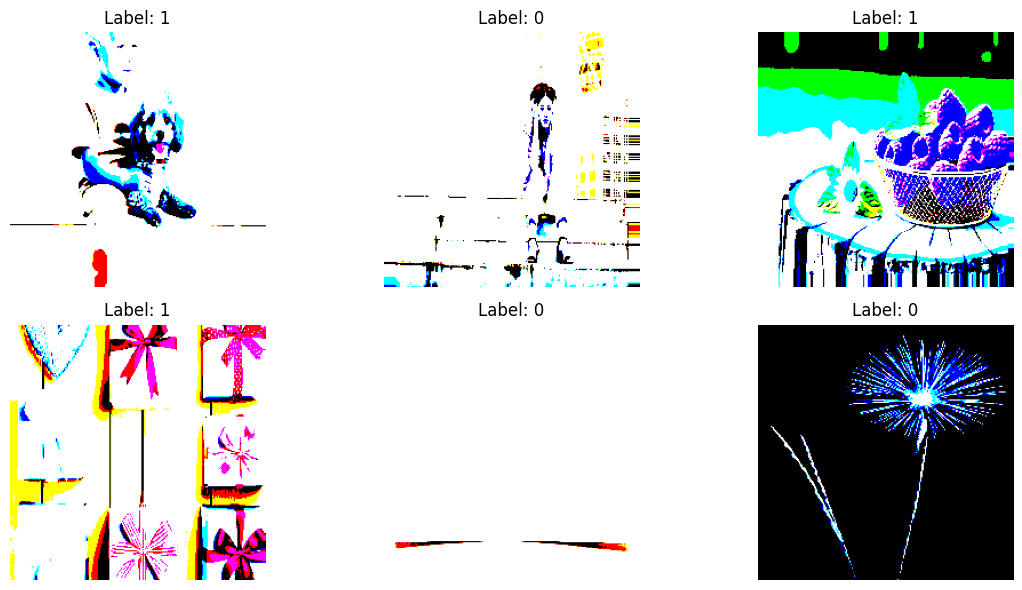

In [11]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

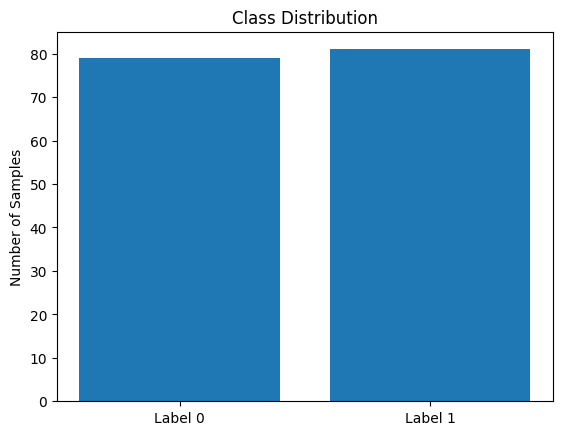

In [12]:
labels_list = []

for i in range(5):
    _, labels = next(train_generator)
    labels_list.extend(labels)

label_counts = collections.Counter(labels_list)

plt.bar(['Label 0', 'Label 1'], [label_counts[0], label_counts[1]])
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.show()

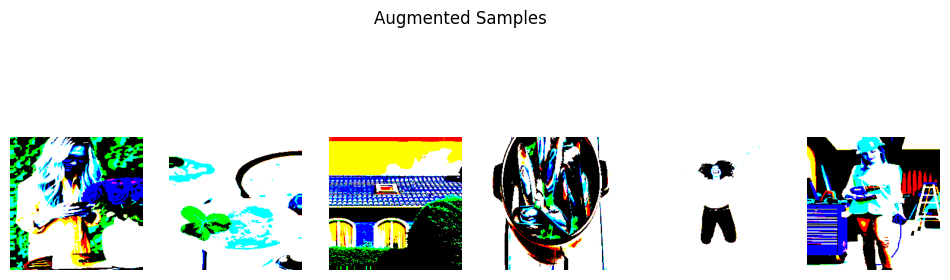

In [13]:
augmented_images, _ = next(train_generator)

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Augmented Samples')
plt.show()


In [14]:
unique, counts = np.unique(train_generator.classes, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(35978), np.int64(1): np.int64(35977)}


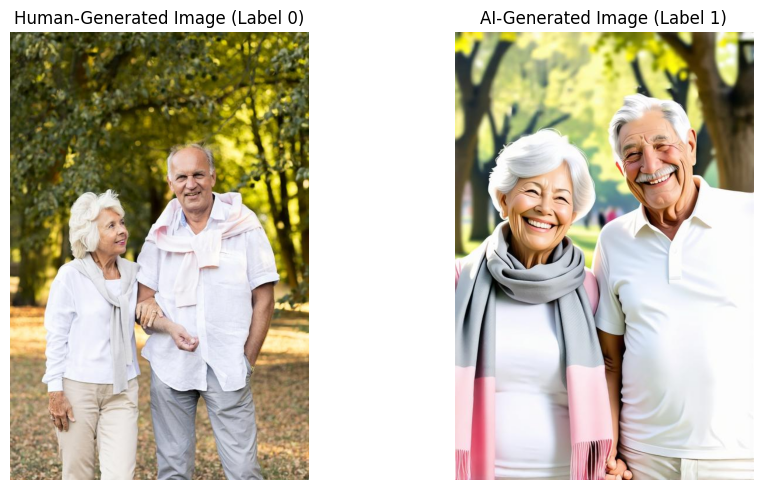

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

# Find a human-generated image (label 0)
human_image_path = train_df[train_df['label'] == '0']['file_name'].iloc[0]

# Find an AI-generated image (label 1)
ai_image_path = train_df[train_df['label'] == '1']['file_name'].iloc[0]

# Load the images
human_image = Image.open(human_image_path)
ai_image = Image.open(ai_image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(human_image)
plt.title('Human-Generated Image (Label 0)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ai_image)
plt.title('AI-Generated Image (Label 1)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model_resnet.layers:
    layer.trainable = False

model_resnet_tl = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model_resnet_tl.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_resnet_tl.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

In [18]:
history_RN = model_resnet_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 1278s 561ms/step - accuracy: 0.8725 - loss: 0.3037 - val_accuracy: 0.9573 - val_loss: 0.1168 - learning_rate: 1.0000e-04
Epoch 2/10
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 1156s 514ms/step - accuracy: 0.9429 - loss: 0.1470 - val_accuracy: 0.9545 - val_loss: 0.1184 - learning_rate: 1.0000e-04
Epoch 3/10
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 1157s 515ms/step - accuracy: 0.9506 - loss: 0.1246 - val_accuracy: 0.9600 - val_loss: 0.1092 - learning_rate: 1.0000e-04
Epoch 4/10
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 1132s 503ms/step - accuracy: 0.9554 - loss: 0.1154 - val_accuracy: 0.9679 - val_loss: 0.0882 - learning_rate: 1.0000e-04
Epoch 5/10
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 1127s 501ms/step - accuracy: 0.9609 - loss: 0.1011 - val_accuracy: 0.9689 - val_loss: 0.0895 - learning_rate: 1.0000e-04
Epoch 6/10
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 1124s 500ms/step - accuracy: 0.9629 - loss: 0.0974 - val_accuracy: 0.9689 - val_loss: 0.0851 - learning_rate: 1.0000e-04
Epoch 7/10
2249/2249 ━

In [20]:
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

images = []

for path in test_df["id"]:
    # Construct the correct image path using train_data_dir
    img_path = os.path.join(train_data_dir, path)
    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Warning: Could not load image at {img_path}. Skipping.")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)
    images.append(img)

X_test = np.array(images)

In [ ]:
preds = model_resnet_tl.predict(X_test).flatten()


In [ ]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": preds
})

submission.to_csv("submission.csv", index=False)


In [ ]:
submission.head()
submission.describe()

In [ ]:
from google.colab import files
files.download("submission.csv")